### IMPORTS AND SETUP

In [39]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging
import shap
import math

logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')

warnings.showwarning = custom_warning_handler

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
import rioxarray as rxr
import rasterio

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.base import clone
from pytorch_tabnet.tab_model import TabNetRegressor
from joblib import dump

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import sys

print("Python executable:", sys.executable)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHOW_PLOTS = True  # if you want to display some bar charts, etc.

Python executable: C:\workspace\python\ai-challenge-2025\.venv\Scripts\python.exe


### FEATURE TOGGLES

In [40]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_50m":  False,
    "building_cov_100m": False,
    "building_cov_200m": False,
    "building_cov_500m": True,

    # distance to water and parks
    "distance_water": True,
    "distance_parks": True,

    # street tree coverage
    "street_tree_cov_500m": True,

    # distance to subway
    "dist_to_closest_subway_station":   True,
    "dist_to_closest_cluster_centroid": True,
    "building_cluster_id":              True,

    # raster-based features
    "lst_value":   True,
    "ndvi_value":  True,
    "ndbi_value":  True,
    "ndwi_value":  True,
    "evi_value":   True,
    "mndwi_value": True,
}

### HELPER FUNCTIONS

In [41]:
def coverage_fraction(geom, polygon_gdf, radius=50):
    """
    coverage_fraction:
      - We do buffer around 'geom' by 'radius'.
      - Clip polygon_gdf with that buffer.
      - Sum area of clipped polygons / area of buffer => coverage fraction.
    """
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0


def building_coverage_fraction(geom, building_gdf, radius=50):
    """Simple wrapper specifically for building footprints coverage."""
    return coverage_fraction(geom, building_gdf, radius)


def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan


def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Return the pixel value from raster at geom's location."""
    x, y = geom.x, geom.y
    val = raster.sel(x=x, y=y, band=band_index, method=method).values
    return float(val)

def find_nearest_building_cluster(pt_geom, gdf_bldg):
    """
    For a given point, find the nearest building (by centroid),
    and return the building's 'bldg_cluster' integer label.
    If no buildings found => returns None.
    """
    distances = gdf_bldg["centroid"].distance(pt_geom)
    if len(distances) == 0:
        return None
    idx_min = distances.idxmin()
    return gdf_bldg.loc[idx_min, "bldg_cluster"]

def nearest_cluster_centroid_label(pt_geom, cluster_centroids):
    """
    For a geometry 'pt_geom', find which cluster centroid
    in 'cluster_centroids' is closest (Euclidian distance),
    and return that cluster label.
    
    cluster_centroids: list of (cluster_label, (cx, cy))
    """
    px, py = pt_geom.x, pt_geom.y
    best_label = None
    best_dist = float("inf")
    for (c_label, (cx, cy)) in cluster_centroids:
        dist_ = math.hypot(cx - px, cy - py)
        if dist_ < best_dist:
            best_dist = dist_
            best_label = c_label
    return best_label

def euclidean_distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def run_dbscan_on_buildings(gdf_buildings, eps_m=400, min_samples=10, N_LARGEST=3):
    """
    Run DBSCAN on gdf_buildings (already in EPSG:2263), 
    pick top N_LARGEST clusters by size, compute centroids.
    
    Returns:
      gdf_buildings (modified with new columns):
        - 'bldg_cluster': DBSCAN integer labels
      cluster_centroids: list of (cluster_label, (cx, cy))
      top_clusters: array of the top N_LARGEST labels
    """
    # Create 'centroid' column if not present
    if "centroid" not in gdf_buildings.columns:
        gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
    
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    
    # DBSCAN
    db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords_bldg)
    labels_bldg = db.labels_
    gdf_buildings["bldg_cluster"] = labels_bldg
    
    # Identify valid clusters (ignore noise = -1)
    valid_mask = (labels_bldg >= 0)
    unique_labels, counts = np.unique(labels_bldg[valid_mask], return_counts=True)
    
    # Sort cluster labels by descending size
    sorted_idx = np.argsort(-counts)  # negative for descending
    sorted_labels = unique_labels[sorted_idx]  # e.g. [0,2,1,3,4,...]
    sorted_counts = counts[sorted_idx]
    
    # pick top N_LARGEST
    top_clusters = sorted_labels[:N_LARGEST]
    
    # compute centroids for top clusters
    cluster_centroids = []
    for clabel in top_clusters:
        cl_mask = (gdf_buildings["bldg_cluster"] == clabel)
        cluster_coords = coords_bldg[cl_mask]
        if len(cluster_coords) > 0:
            mp = MultiPoint(cluster_coords)
            c_centroid = mp.centroid
            cluster_centroids.append((clabel, (c_centroid.x, c_centroid.y)))
    
    return gdf_buildings, cluster_centroids, top_clusters

def dist_to_closest_cluster_centroid_feature(geom, cluster_centroids):
    """
    For each geometry, compute distance to the nearest centroid
    among the top N largest clusters.
    cluster_centroids: list of (label, (cx, cy)) only for top clusters
    """
    px, py = geom.x, geom.y
    dmin = float("inf")
    for (lbl, (cx, cy)) in cluster_centroids:
        d = euclidean_distance(px, py, cx, cy)
        if d < dmin:
            dmin = d
    return dmin

### LOAD GEOSPATIAL DATA

In [42]:
print("Loading building footprints, water, parks, street trees, subway stations...")

# 4.1 Building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint_1GB.kml").to_crs("EPSG:2263")

# 4.2 Water polygons
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# 4.3 Parks polygons
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# 4.4 Street Trees
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# approximate canopy with 2m buffer
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)

# 4.5 Subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

print("Done loading geospatial data.")

Loading building footprints, water, parks, street trees, subway stations...
Done loading geospatial data.


### LOAD + CHECK RASTERS

In [43]:
print("Loading reprojected LST + Indices...")

lst_tiff_path = "Landsat_LST_v5_median_0601_0901.tiff"
indices_tiff_path = "S2_indices_v5_median_0601_0901.tiff"

lst_raster = rxr.open_rasterio(lst_tiff_path)
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio(indices_tiff_path)
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")
if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.995
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


Tiff Bounds: BoundingBox(left=-74.0101509162774, bottom=40.749820337765, right=-73.85977362558391, top=40.8802551203737)
CRS: EPSG:4326
Width, Height: 558 484
Number of bands: 1


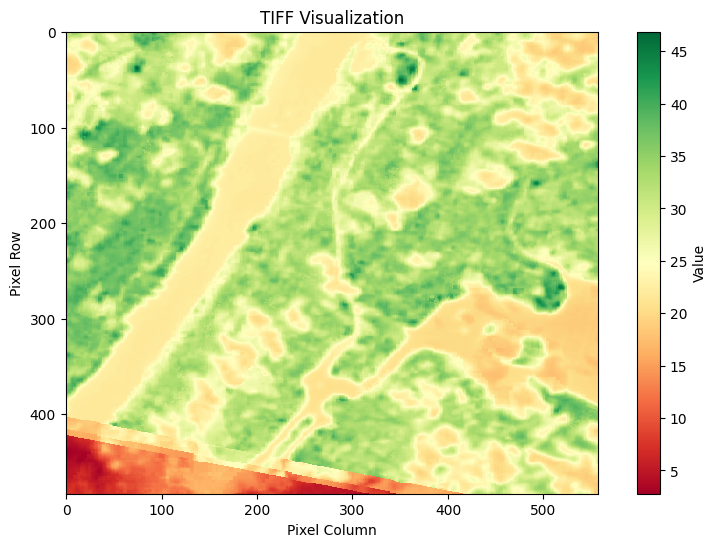

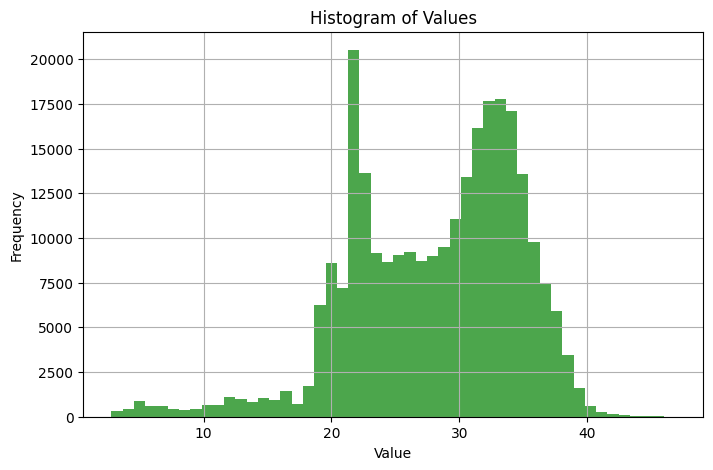

In [51]:
if SHOW_PLOTS:
    # Open the TIFF file
    with rasterio.open(lst_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

Tiff Bounds: BoundingBox(left=-74.0100610851599, bottom=40.75, right=-73.85995328781891, top=40.8800754581387)
CRS: EPSG:4326
Width, Height: 1671 1448
Number of bands: 5


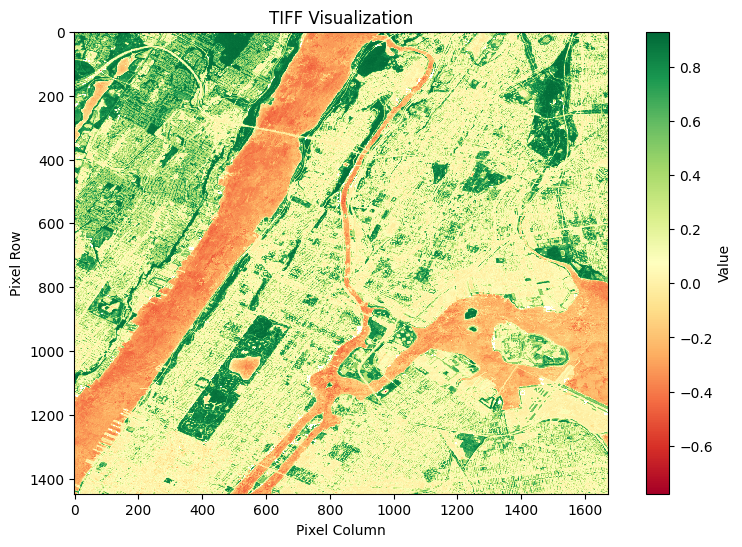

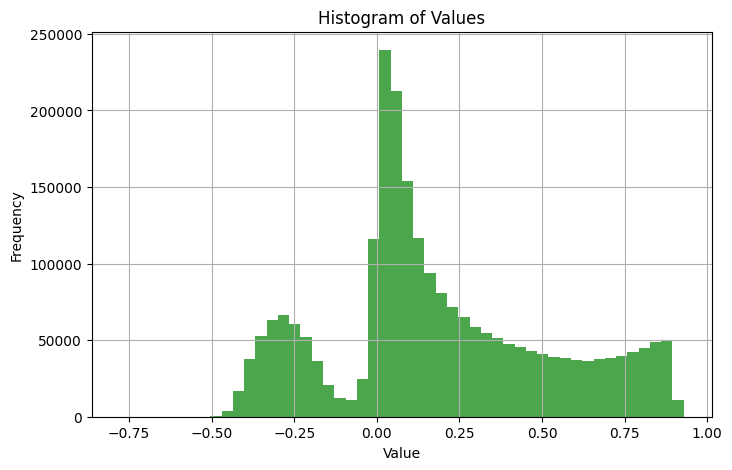

In [52]:
if SHOW_PLOTS:
    # Open the TIFF file
   
    with rasterio.open(indices_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

### LOAD TRAINING DATA

In [46]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
print("df_train shape:", df_train.shape)

gdf_train = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading Training CSV ...
df_train shape: (11229, 4)


In [47]:
import geopandas as gpd
from shapely.geometry import box

# 1. Extract the total bounds of gdf_train
minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# 2. Define a buffer in the same units as your CRS (here, meters)
buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# 3. Create an expanded bounding box
expanded_bbox = box(minx_train - buffer, 
                    miny_train - buffer, 
                    maxx_train + buffer, 
                    maxy_train + buffer)

# Optional: If you want to see the coordinates of the expanded bounding box:
print("Expanded Bounding Box:", expanded_bbox.bounds)

# 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# Check the total bounds of the new subset
print("Subset Total Bounds:", gdf_buildings.total_bounds)
print("Train Total Bounds:", gdf_train.total_bounds)

Expanded Bounding Box: (984785.411382811, 214727.52933294218, 1018620.8402454641, 253422.67726362712)
Subset Total Bounds: [ 984092.05017281  214355.31379316 1019093.78397498  253922.21989541]
Train Total Bounds: [ 985785.41138281  215727.52933294 1017620.84024546  252422.67726363]


In [48]:
# 1) Run DBSCAN
N_LARGEST = 6
eps_m = 500
min_samples = 50
gdf_buildings, cluster_centroids, top_clusters = run_dbscan_on_buildings(
    gdf_buildings, 
    eps_m=eps_m,
    min_samples=min_samples,
    N_LARGEST=N_LARGEST
)

print(f"Top {N_LARGEST} clusters by building count: {top_clusters}")
print("Cluster centroids for top N largest clusters:")
for (lbl, (cx, cy)) in cluster_centroids:
    print(f"  Cluster {lbl} => centroid=({cx:.2f}, {cy:.2f})")

Top 6 clusters by building count: [3 0 2 5 1 4]
Cluster centroids for top N largest clusters:
  Cluster 3 => centroid=(1009637.66, 218641.78)
  Cluster 0 => centroid=(996889.92, 229691.73)
  Cluster 2 => centroid=(1010724.93, 238797.23)
  Cluster 5 => centroid=(1012340.88, 249517.53)
  Cluster 1 => centroid=(987293.55, 216974.45)
  Cluster 4 => centroid=(1017709.54, 241125.19)


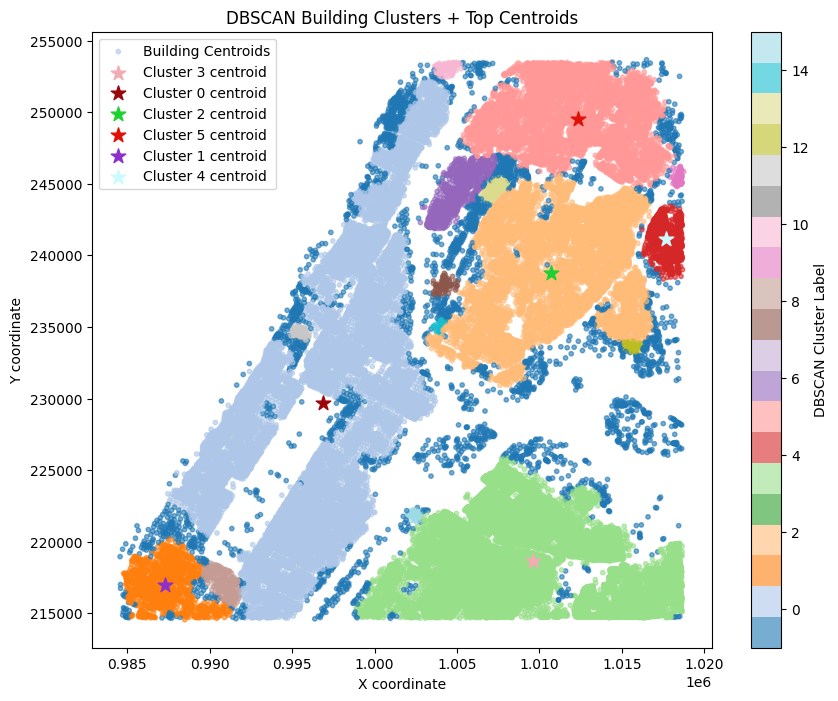

In [49]:
if SHOW_PLOTS:
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    labels_bldg = gdf_buildings["bldg_cluster"].values
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        coords_bldg[:, 0],
        coords_bldg[:, 1],
        c=labels_bldg,
        cmap='tab20',
        s=10,
        alpha=0.6,
        label="Building Centroids"
    )
    # Mark cluster centroids
    for (lbl, (cx, cy)) in cluster_centroids:
        random_color = mcolors.to_rgba((random.random(), random.random(), random.random()))
        ax.scatter(cx, cy, color=random_color, marker='*', s=120, label=f"Cluster {lbl} centroid")
    
    ax.set_title("DBSCAN Building Clusters + Top Centroids")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    cb = plt.colorbar(scatter, ax=ax, label="DBSCAN Cluster Label")
    
    # Deduplicate legend entries
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    
    plt.show()

### BUILD TRAINING FEATURES

In [53]:
print("Building training features...")

# We'll store arrays in a dictionary keyed exactly by the same name as FEATURE_FLAGS
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val}  
# (Only create arrays for the flags that are True)

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")
for i, row in gdf_train.iterrows():
    if i % 1000 == 0:
        percent_done = (i / total_rows) * 100
        print(f"  -> {percent_done:.2f}% done")

    geom = row.geometry

    # 7.1 building coverage (various radii)
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_train["building_cov_50m"].append(b50)

    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_train["building_cov_100m"].append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_train["building_cov_200m"].append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_train["building_cov_500m"].append(b500)

    # 7.2 distance to water
    if FEATURE_FLAGS["distance_water"]:
        dist_w = distance_to_polygons(geom, gdf_water)
        features_dict_train["distance_water"].append(dist_w)

    # 7.3 distance to parks
    if FEATURE_FLAGS["distance_parks"]:
        dist_p = distance_to_polygons(geom, gdf_parks)
        features_dict_train["distance_parks"].append(dist_p)

    # 7.4 street tree coverage in 500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_train["street_tree_cov_500m"].append(tree_500)

    # 7.5 distance to closest subway station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_subway = gdf_stations.geometry.distance(geom)
        dist_sub = dists_subway.min() if len(dists_subway) > 0 else 0
        features_dict_train["dist_to_closest_subway_station"].append(dist_sub)

    # 7.6 Raster-based: lst_value, ndvi_value, ndbi_value, ndwi_value, evi_value, mndwi_value
    if FEATURE_FLAGS["lst_value"]:
        lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_train["lst_value"].append(lst_val)

    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_train["ndvi_value"].append(ndvi_val)

    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_train["ndbi_value"].append(ndbi_val)

    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_train["ndwi_value"].append(ndwi_val)

    if FEATURE_FLAGS["evi_value"]:
        evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
        features_dict_train["evi_value"].append(evi_value)
        
    if FEATURE_FLAGS["mndwi_value"]:
        mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
        features_dict_train["mndwi_value"].append(mndwi_value)

    # 7.7 Mathematically calculated neighbourhoods and distances from their centroids
    if FEATURE_FLAGS["building_cluster_id"]:
        c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
        if c_str is not None:
            c_str = f"N{c_str}"
        else:
            c_str = "other"
        # print(c_str)
        features_dict_train["building_cluster_id"].append(c_str)
    
    if FEATURE_FLAGS["dist_to_closest_cluster_centroid"]:
        dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
        features_dict_train["dist_to_closest_cluster_centroid"].append(dmin)

print("100.00% done")

Building training features...
total rows: 11229
  -> 0.00% done
  -> 8.91% done
  -> 17.81% done
  -> 26.72% done
  -> 35.62% done
  -> 44.53% done
  -> 53.43% done
  -> 62.34% done
  -> 71.24% done
  -> 80.15% done
  -> 89.06% done
  -> 97.96% done
100.00% done


### OUTLIER REMOVAL

In [54]:
# E.g. cap y above 99.5th percentile
cap_quantile= 0.995
cap_val= gdf_train["UHI Index"].quantile(cap_quantile)
mask_out= (gdf_train["UHI Index"] > cap_val)
if mask_out.sum()>0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"] = cap_val

Capping 57 outliers above Q=0.995 at 1.041


### CREATE TRAINING DATAFRAME

In [55]:
# For each True flag in FEATURE_FLAGS, add the corresponding array to gdf_train as a column
for feat_key, feat_values in features_dict_train.items():
    gdf_train[feat_key] = feat_values

# Build final feature_cols from keys that are True
feature_cols = [k for k, v in FEATURE_FLAGS.items() if v]

df_train_feat = gdf_train[feature_cols].fillna(0.0)

In [56]:
# One-hot encoding
cat_col = "building_cluster_id"

# 1. Convert to string explicitly (might already be string, but just to be sure)
df_train_feat[cat_col] = df_train_feat[cat_col].astype(str)

# 2. Create dummies in training
train_dummies = pd.get_dummies(df_train_feat[cat_col], prefix=cat_col)
df_train_feat = pd.concat([df_train_feat.drop(columns=[cat_col]), train_dummies], axis=1)

In [57]:
X = df_train_feat.values
y = gdf_train["UHI Index"].values

print("Final train feature shape:", X.shape)
print("Feature columns:", feature_cols)

Final train feature shape: (11229, 17)
Feature columns: ['building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'building_cluster_id', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value']


In [58]:
gdf_train["building_cluster_id"].unique()

array(['N2', 'N0', 'N1', 'N5', 'N4'], dtype=object)

In [59]:
gdf_train["building_cluster_id"].value_counts(dropna=False)

building_cluster_id
N0    4394
N2    3912
N5    1341
N1    1164
N4     418
Name: count, dtype: int64

In [60]:
df_train_feat.describe(include='all')

,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229,11229,11229,11229,11229
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6835,10065,7317,10811,9888
mean,0.314795,1891.184531,362.798049,0.001550,1346.473005,5445.973331,31.372035,0.208573,0.021262,-0.227057,1.703159,-0.253940,NaN,NaN,NaN,NaN,NaN
std,0.119932,1298.246512,360.343364,0.000785,909.205876,2298.443570,3.831732,0.203159,0.135191,0.172967,37.160912,0.124111,NaN,NaN,NaN,NaN,NaN
min,0.000000,20.933619,0.000000,0.000000,7.600310,81.037548,20.230583,-0.182557,-0.438507,-0.800440,-400.000000,-0.630162,NaN,NaN,NaN,NaN,NaN
25%,0.251169,930.568027,76.262961,0.001008,735.246718,3664.757644,29.452401,0.056308,-0.052965,-0.311675,0.327422,-0.336400,NaN,NaN,NaN,NaN,NaN
50%,0.324589,1617.923389,284.983308,0.001570,1125.301971,5271.998835,32.296193,0.133852,0.033894,-0.170163,0.833851,-0.245953,NaN,NaN,NaN,NaN,NaN
75%,0.397363,2415.031074,505.198800,0.002091,1725.086477,7088.635506,34.070146,0.299983,0.110608,-0.097191,1.678772,-0.171332,NaN,NaN,NaN,NaN,NaN


In [61]:
df_train_feat

,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5
0,0.307180,3536.717021,371.277131,0.001072,1288.844077,3531.003851,33.861647,0.422712,-0.132830,-0.397895,2.137109,-0.279856,False,False,True,False,False
1,0.304410,3520.867715,358.889116,0.001084,1311.950618,3553.899683,33.861647,0.514043,-0.193615,-0.478316,2.238339,-0.313758,False,False,True,False,False
2,0.302863,3504.846309,344.200944,0.001075,1337.471817,3579.354357,33.861647,0.510994,-0.190279,-0.500163,1.907621,-0.342478,False,False,True,False,False
3,0.304253,3487.673871,330.119247,0.001026,1364.019827,3605.761431,33.950515,0.527638,-0.182266,-0.500987,2.242312,-0.350749,False,False,True,False,False
4,0.309865,3470.826136,320.290749,0.000978,1387.305279,3628.706533,33.950515,0.527638,-0.182266,-0.500987,2.242312,-0.350749,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,0.000000,569.780991,0.000000,0.000000,2170.218829,2582.504707,22.636869,0.626784,-0.216499,-0.596123,2.437567,-0.435878,True,False,False,False,False
11225,0.000000,559.973656,0.000000,0.000000,2168.641060,2592.291925,22.636869,0.766208,-0.306449,-0.660586,2.636917,-0.444024,True,False,False,False,False
11226,0.000000,543.787136,0.000000,0.000000,2163.730048,2608.068718,22.636869,0.766208,-0.306449,-0.660586,2.636917,-0.444024,True,False,False,False,False
11227,0.000000,536.117477,0.000000,0.000000,2160.203993,2615.360359,22.636869,0.680930,-0.238373,-0.621814,2.560588,-0.450167,True,False,False,False,False


In [62]:
gdf_train

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,building_cluster_id,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (1009393.606 235526.824),0.307180,3536.717021,371.277131,0.001072,1288.844077,3531.003851,N2,33.861647,0.422712,-0.132830,-0.397895,2.137109,-0.279856
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (1009388.093 235504.35),0.304410,3520.867715,358.889116,0.001084,1311.950618,3553.899683,N2,33.861647,0.514043,-0.193615,-0.478316,2.238339,-0.313758
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (1009380.276 235480.052),0.302863,3504.846309,344.200944,0.001075,1337.471817,3579.354357,N2,33.861647,0.510994,-0.190279,-0.500163,1.907621,-0.342478
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (1009372.92 235454.541),0.304253,3487.673871,330.119247,0.001026,1364.019827,3605.761431,N2,33.950515,0.527638,-0.182266,-0.500987,2.242312,-0.350749
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (1009368.791 235431.463),0.309865,3470.826136,320.290749,0.000978,1387.305279,3628.706533,N2,33.950515,0.527638,-0.182266,-0.500987,2.242312,-0.350749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,POINT (996143.074 227219.577),0.000000,569.780991,0.000000,0.000000,2170.218829,2582.504707,N0,22.636869,0.626784,-0.216499,-0.596123,2.437567,-0.435878
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,POINT (996139.388 227210.467),0.000000,559.973656,0.000000,0.000000,2168.641060,2592.291925,N0,22.636869,0.766208,-0.306449,-0.660586,2.636917,-0.444024
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,POINT (996131.087 227196.498),0.000000,543.787136,0.000000,0.000000,2163.730048,2608.068718,N0,22.636869,0.766208,-0.306449,-0.660586,2.636917,-0.444024
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,POINT (996126.012 227190.422),0.000000,536.117477,0.000000,0.000000,2160.203993,2615.360359,N0,22.636869,0.680930,-0.238373,-0.621814,2.560588,-0.450167


### DEFINE STRATIFIED CV

In [63]:
def make_stratified_bins(target, n_bins=10):
    """Bin the continuous target into discrete intervals for use in StratifiedKFold."""
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

K_FOLDS = 10
y_bins = make_stratified_bins(y, n_bins=10)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [64]:
models_and_params = {
    "BayesianRidge": (
        BayesianRidge(),
        {
            "alpha_init": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
            "lambda_init": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
        },
        30
    ),
    "ElasticNet": (
        ElasticNet(random_state=RANDOM_SEED),
        {
            "alpha": [0.001, 0.005, 0.01, 0.1, 1.0],
            "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.8, 0.9],
        },
        30
    ),
    "XGBoost": (
        xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "learning_rate": [0.01, 0.05, 0.1, 0.15],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            # "booster": ["gbtree", "dart"],
            # "gamma": [0],
            # "reg_alpha": [0, 0.1, 0.5],
            # "reg_lambda": [1.0],
            "subsample": [0.7, 0.8, 0.9],
            "colsample_bytree": [0.7, 0.8, 0.9]
        },
        300
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
        {
            "iterations": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [5, 6, 7, 8, 9, 10, 11],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "random_strength": [1, 2, 3, 4],
        },
        200
    ),
    "LightGBM": (
        lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "learning_rate": [0.05, 0.1, 0.15, 0.2],
            "subsample": [0.5, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8],
            # "boosting_type": ["gbdt", "rf"],
            "num_leaves": [31, 63, 127],
            "reg_alpha": [0, 0.1, 0.5],
            "reg_lambda": [0.5, 1.0, 2.0],
        },
        200
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "max_iter": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "max_leaf_nodes": [31, 63, 127],
            "l2_regularization": [0.0, 0.1, 0.5],
            "quantile": [0.1, 0.5, 0.8],
            "min_samples_leaf": [5, 10, 15],
            # "warm_start": [False],
        },
        200
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            "splitter": ["best", "random"],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
        },
        200
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        200
    ),
    "ExtraTrees": (
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_split": [3, 4, 5, 6],
            "min_samples_leaf": [1, 2, 3, 4],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "ccp_alpha": [0.0, 0.001],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        300
    ),
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [2, 3, 4, 5],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [5, 10, 15, 20, 25, 30, 35, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        },
        1000
    ),
    # "NeuralNet": (
    #     MLPRegressor(random_state=RANDOM_SEED, max_iter=500),
    #     {
    #         "hidden_layer_sizes": [
    #             (64,), (128,), (64,64), (128,64),
    #         ],
    #         "activation": ["relu", "tanh"],
    #         "alpha": [1e-5, 1e-4, 1e-3],  # L2 reg
    #         "learning_rate_init": [0.001, 0.01],
    #         "solver": ["adam"],  # LBFGS is slower, sgd is less stable
    #     },
    #     10
    # ),
    # "SVR": (
    #     SVR(),
    #     {
    #         "kernel": ["rbf", "linear", "poly"],
    #         "C": [0.1, 1, 10],
    #         "epsilon": [0.01, 0.1, 0.5, 1.0],
    #         "gamma": ["scale"],
    #     },
    #     20
    # ),
    # "GPR": (
    #     GaussianProcessRegressor(random_state=RANDOM_SEED),
    #     {
    #         # We'll try a small kernel set
    #         "alpha": [1e-10, 1e-5, 1e-2],
    #         "kernel": [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)],
    #     },
    #     2
    # ),
}

### RANDOM SEARCH FOR EACH MODEL

In [65]:
results = []
for model_name, (model, param_grid, n_iter) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,  # <--- use the model-specific n_iter
        cv=list(skf.split(X, y_bins)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=3
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)
results_df.to_csv("results_df_v15.csv", index=False, sep='|')


=== Searching BayesianRidge ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Searching ElasticNet ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Searching XGBoost ===
Fitting 10 folds for each of 300 candidates, totalling 3000 fits

=== Searching CatBoost ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching HistGradientBoosting ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching DecisionTree ===
Fitting 10 folds for each of 56 candidates, totalling 560 fits

=== Searching RandomForest ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching ExtraTrees ===
Fitting 10 folds for each of 300 candidates, totalling 3000 fits

=== Searching KNeighbors ===
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits

Final Cross-Val Results:
                  

In [66]:
results_df

,Model,Best Estimator,Best Score (CV),Best Params
9,KNeighbors,"KNeighborsRegressor(algorithm='kd_tree', leaf_...",0.975089,"{'weights': 'distance', 'p': 2, 'n_neighbors':..."
8,ExtraTrees,"(ExtraTreeRegressor(max_depth=40, min_samples_...",0.969370,"{'n_estimators': 1000, 'min_samples_split': 3,..."
2,XGBoost,"XGBRegressor(base_score=None, booster=None, ca...",0.962986,"{'subsample': 0.8, 'n_estimators': 800, 'max_d..."
4,LightGBM,"LGBMRegressor(colsample_bytree=0.6, learning_r...",0.956914,"{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alp..."
3,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,0.956195,"{'random_strength': 1, 'max_depth': 10, 'learn..."
7,RandomForest,"(DecisionTreeRegressor(max_depth=30, max_featu...",0.955134,"{'n_estimators': 700, 'min_samples_split': 2, ..."
5,HistGradientBoosting,"HistGradientBoostingRegressor(max_depth=35, ma...",0.945710,"{'quantile': 0.5, 'min_samples_leaf': 5, 'max_..."
6,DecisionTree,"DecisionTreeRegressor(max_depth=30, min_sample...",0.894201,"{'splitter': 'random', 'min_samples_leaf': 2, ..."
0,BayesianRidge,"BayesianRidge(alpha_init=0.0001, lambda_init=1...",0.316782,"{'lambda_init': 1e-08, 'alpha_init': 0.0001}"
1,ElasticNet,"ElasticNet(alpha=0.001, l1_ratio=0.1, random_s...",0.287628,"{'l1_ratio': 0.1, 'alpha': 0.001}"


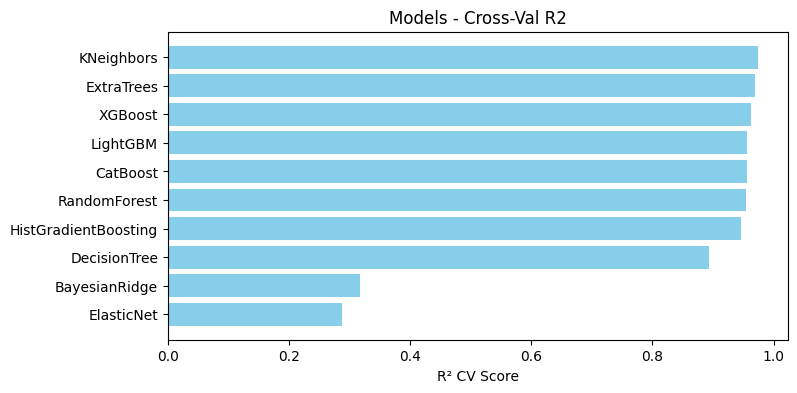

In [67]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R² CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

### VALIDATION DATA

In [68]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading validation (submission) data...


### FEATURE ENGINEERING FOR VALIDATION SET

In [69]:
total_rows_val = len(gdf_val)
print(f"total rows: {total_rows_val}")

total rows: 1040


In [71]:
print("Building validation features...")

features_dict_val = {key: [] for key, val in FEATURE_FLAGS.items() if val}
for idx, row in gdf_val.iterrows():
    if idx % 100 == 0:
        percent_val = (idx / total_rows_val) * 100
        print(f"  -> {percent_val:.2f}% done")

    geom = row.geometry

    # 7.1 building coverage (various radii)
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_val["building_cov_50m"].append(b50)

    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_val["building_cov_100m"].append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_val["building_cov_200m"].append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_val["building_cov_500m"].append(b500)

    # 7.2 distance to water
    if FEATURE_FLAGS["distance_water"]:
        dw = distance_to_polygons(geom, gdf_water)
        features_dict_val["distance_water"].append(dw)

    # 7.3 distance to parks
    if FEATURE_FLAGS["distance_parks"]:
        dp = distance_to_polygons(geom, gdf_parks)
        features_dict_val["distance_parks"].append(dp)

    # 7.4 street tree coverage in 500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_val["street_tree_cov_500m"].append(tree_500)

    # 7.5 distance to closest subway station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_sub = gdf_stations.geometry.distance(geom)
        dist_sub = dists_sub.min() if len(dists_sub) > 0 else 0
        features_dict_val["dist_to_closest_subway_station"].append(dist_sub)

    # 7.6 Raster-based: lst_value, ndvi_value, ndbi_value, ndwi_value, evi_value, mndwi_value
    if FEATURE_FLAGS["lst_value"]:
        lv = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_val["lst_value"].append(lv)

    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_val["ndvi_value"].append(ndvi_val)

    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_val["ndbi_value"].append(ndbi_val)

    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_val["ndwi_value"].append(ndwi_val)

    if FEATURE_FLAGS["evi_value"]:
        evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
        features_dict_val["evi_value"].append(evi_value)
        
    if FEATURE_FLAGS["mndwi_value"]:
        mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
        features_dict_val["mndwi_value"].append(mndwi_value)

    # 7.7 Mathematically calculated neighbourhoods and distances from their centroids
    if FEATURE_FLAGS["building_cluster_id"]:
        c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
        if c_str is not None:
            c_str = f"N{c_str}"
        else:
            c_str = "other"
        features_dict_val["building_cluster_id"].append(c_str)
    
    if FEATURE_FLAGS["dist_to_closest_cluster_centroid"]:
        dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
        features_dict_val["dist_to_closest_cluster_centroid"].append(dmin)

print("100.00% done")

Building validation features...
  -> 0.00% done
  -> 9.62% done
  -> 19.23% done
  -> 28.85% done
  -> 38.46% done
  -> 48.08% done
  -> 57.69% done
  -> 67.31% done
  -> 76.92% done
  -> 86.54% done
  -> 96.15% done
100.00% done


In [72]:
# Attach columns to df_val
for feat_key, feat_values in features_dict_val.items():
    df_val[feat_key] = feat_values

# Build final X_val
feature_cols = [k for k, v in FEATURE_FLAGS.items() if v]
df_val_feat = df_val[feature_cols].fillna(0.0)

In [73]:
# One-hot encoding
cat_col = "building_cluster_id"

# 1. Convert to string explicitly (might already be string, but just to be sure)
df_val_feat[cat_col] = df_val_feat[cat_col].astype(str)

# 2. Create dummies in validation
val_dummies = pd.get_dummies(df_val_feat[cat_col], prefix=cat_col)
df_val_feat = pd.concat([df_val_feat.drop(columns=[cat_col]), val_dummies], axis=1)

In [74]:
X_val = df_val_feat.values

print("Validation shape:", X_val.shape)
print("feature_cols:", feature_cols)

Validation shape: (1040, 17)
feature_cols: ['building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'building_cluster_id', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value']


In [75]:
df_val_feat.describe(include='all')

,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040,1040,1040,1040,1040
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,637,926,672,996,929
mean,0.319223,1862.946328,354.089910,0.001580,1343.433165,5447.006346,31.457096,0.209019,0.022121,-0.227836,3.060259,-0.256118,NaN,NaN,NaN,NaN,NaN
std,0.122777,1291.951419,352.246984,0.000805,927.888462,2324.047330,3.753276,0.208154,0.138776,0.176984,69.401017,0.128217,NaN,NaN,NaN,NaN,NaN
min,0.000000,37.485593,0.000000,0.000000,14.814218,85.424731,20.292107,-0.068966,-0.438507,-0.784428,-75.384613,-0.610677,NaN,NaN,NaN,NaN,NaN
25%,0.254554,924.712590,74.049553,0.001006,735.051227,3573.428121,29.593394,0.056887,-0.051713,-0.307304,0.332345,-0.343701,NaN,NaN,NaN,NaN,NaN
50%,0.330494,1569.105207,284.669629,0.001600,1117.922503,5259.201391,32.422660,0.131039,0.036437,-0.169910,0.779309,-0.244562,NaN,NaN,NaN,NaN,NaN
75%,0.401599,2394.165190,505.034117,0.002139,1737.766898,7277.912476,34.064164,0.288634,0.115622,-0.098485,1.630996,-0.166051,NaN,NaN,NaN,NaN,NaN


In [76]:
df_val_feat

,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5
0,0.398831,1598.865845,16.915051,0.002833,1261.529232,5679.423728,31.373328,0.634263,-0.152237,-0.594313,2.550014,-0.486053,True,False,False,False,False
1,0.407916,1680.392927,17.191011,0.002616,1190.837376,5719.646071,31.373328,0.618722,-0.220892,-0.559599,2.485978,-0.386481,True,False,False,False,False
2,0.316181,548.782831,171.943979,0.001872,1143.271023,4582.975688,27.504129,0.128751,0.091936,-0.157573,0.666740,-0.245946,True,False,False,False,False
3,0.387198,1867.133018,148.747368,0.002479,1028.151027,5828.652460,31.629680,0.053738,0.121500,-0.154191,0.161121,-0.270621,True,False,False,False,False
4,0.470616,996.831598,407.007100,0.002761,789.915025,5404.633921,25.829300,0.543229,-0.166191,-0.503679,1.908683,-0.368319,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.382683,3414.672802,402.099179,0.001819,953.712505,5141.068010,36.346547,0.061162,0.160315,-0.092569,0.332557,-0.249186,False,False,True,False,False
1036,0.246021,674.384502,97.740724,0.001466,2274.339527,8420.725558,28.170643,0.546473,-0.131735,-0.493377,1.593209,-0.386780,False,False,True,False,False
1037,0.358127,1723.423905,574.938724,0.001841,1385.796145,10071.833367,35.143404,0.127425,-0.038625,-0.131476,1.834192,-0.093325,False,False,False,False,True
1038,0.424741,4002.581340,1176.932684,0.001072,293.362888,4313.414610,35.584329,0.207508,0.181882,-0.266793,0.815152,-0.427910,False,False,True,False,False


In [77]:
df_val

,Longitude,Latitude,UHI Index,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,building_cluster_id,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value
0,-73.971665,40.788763,NaN,0.398831,1598.865845,16.915051,0.002833,1261.529232,5679.423728,N0,31.373328,0.634263,-0.152237,-0.594313,2.550014,-0.486053
1,-73.971928,40.788875,NaN,0.407916,1680.392927,17.191011,0.002616,1190.837376,5719.646071,N0,31.373328,0.618722,-0.220892,-0.559599,2.485978,-0.386481
2,-73.967080,40.789080,NaN,0.316181,548.782831,171.943979,0.001872,1143.271023,4582.975688,N0,27.504129,0.128751,0.091936,-0.157573,0.666740,-0.245946
3,-73.972550,40.789082,NaN,0.387198,1867.133018,148.747368,0.002479,1028.151027,5828.652460,N0,31.629680,0.053738,0.121500,-0.154191,0.161121,-0.270621
4,-73.969697,40.787953,NaN,0.470616,996.831598,407.007100,0.002761,789.915025,5404.633921,N0,25.829300,0.543229,-0.166191,-0.503679,1.908683,-0.368319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,0.382683,3414.672802,402.099179,0.001819,953.712505,5141.068010,N2,36.346547,0.061162,0.160315,-0.092569,0.332557,-0.249186
1036,-73.931033,40.833178,NaN,0.246021,674.384502,97.740724,0.001466,2274.339527,8420.725558,N2,28.170643,0.546473,-0.131735,-0.493377,1.593209,-0.386780
1037,-73.934647,40.854542,NaN,0.358127,1723.423905,574.938724,0.001841,1385.796145,10071.833367,N5,35.143404,0.127425,-0.038625,-0.131476,1.834192,-0.093325
1038,-73.917223,40.815413,NaN,0.424741,4002.581340,1176.932684,0.001072,293.362888,4313.414610,N2,35.584329,0.207508,0.181882,-0.266793,0.815152,-0.427910


### ENSEMBLE: PICK TOP 3 MODELS

In [78]:
topN = results_df.head(3).reset_index(drop=True)
base_models = []
for i in range(len(topN)):
    mname = topN.loc[i, "Model"]
    mest = topN.loc[i, "Best Estimator"]
    base_models.append((mname, mest))

print("\nTop Models from CV:\n", base_models)

modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]


Top Models from CV:
 [('KNeighbors', KNeighborsRegressor(algorithm='kd_tree', leaf_size=15, metric='chebyshev',
                    n_neighbors=2, weights='distance')), ('ExtraTrees', ExtraTreesRegressor(max_depth=40, min_samples_split=3, n_estimators=1000,
                    random_state=42)), ('XGBoost', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
      

### WEIGHTED SEARCH

In [79]:
from sklearn.model_selection import KFold
def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001):
    """
    Find best weights w1, w2, w3 that sum to 1
    for an ensemble of (modelA, modelB, modelC).
    Minimizes over entire data via out-of-fold approach.
    """
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]

        ma = clone(modelA).fit(XA, ya)
        mb = clone(modelB).fit(XA, ya)
        mc = clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = ma.predict(XV)
        predsB_oof[valid_idx] = mb.predict(XV)
        predsC_oof[valid_idx] = mc.predict(XV)

    best_combo, best_r2 = (0,0,0), -999

    # Count total iterations
    num_steps = int(1 / increments) + 1
    total_iterations = (num_steps * (num_steps + 1)) // 2  # Sum of arithmetic series
    iteration_count = 0
    last_reported_progress = 0
    
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0:
                continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1, w2, w3)
            # Track progress
            iteration_count += 1
            progress = (iteration_count / total_iterations) * 100
            if round(progress) > last_reported_progress:
                last_reported_progress = round(progress)
                print(f"Progress: {last_reported_progress}%")
    return best_combo, best_r2

In [80]:
# Weighted 3-model ensemble with fine increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001)
w1, w2, w3 = best_combo
print(f"\nBest 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R²={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X, y)
finalB = clone(modelB).fit(X, y)
finalC = clone(modelC).fit(X, y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val

submission_3model_path = "output/submission_v15_3model_weighted.csv"
os.makedirs("output", exist_ok=True)
df_val[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_3model_path, index=False)
print(f"Saved 3-model weighted ensemble submission => {submission_3model_path}")

Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

### SAVE THE WEIGHTED ENSEMBLE

In [81]:
import pickle

ensemble_dict = {
    "model_names": [base_models[0][0], base_models[1][0], base_models[2][0]],
    "models": [finalA, finalB, finalC],
    "weights": (w1, w2, w3)
}
os.makedirs("models", exist_ok=True)
with open("models/3model_weighted_ensemble_v15.pkl","wb") as f:
    pickle.dump(ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights (v15).")

Saved 3-model weighted ensemble with discovered weights (v15).


### ENSEMBLE WITH SIMPLE AVERAGE

In [82]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)

avg3 = (val_predsA + val_predsB + val_predsC) / 3
df_val["UHI Index"] = avg3
submission_avg3_path = "output/submission_v15-avg3.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg3_path, index=False)
print(f"Saved simple average => {submission_avg3_path}")

avg2 = (val_predsA + val_predsB) / 2
df_val["UHI Index"] = avg2
submission_avg2_path = "output/submission_v15-avg2.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg2_path, index=False)
print(f"Saved simple average => {submission_avg2_path}")

df_val["UHI Index"] = val_predsA
submission_top1_path = "output/submission_v15-1.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_top1_path, index=False)
print(f"Saved simple average => {submission_top1_path}")

Saved simple average => output/submission_v15-avg3.csv
Saved simple average => output/submission_v15-avg2.csv
Saved simple average => output/submission_v15-1.csv


### META-LEARNERS

In [85]:
print("\nGenerating OOF predictions for meta-learner...")
oof_preds = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    print(f"  -> Base model {idx}: {mname}")
    model_clone = clone(base_model)
    for train_idx, valid_idx in skf.split(X, y_bins):
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]
        model_clone.fit(X_trainF, y_trainF)
        oof_preds[valid_idx, idx] = model_clone.predict(X_validF)

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso": Lasso(alpha=1e-5, random_state=RANDOM_SEED),
    "XGB": xgb.XGBRegressor(n_estimators=400, learning_rate=0.01,
                            max_depth=15, random_state=RANDOM_SEED,
                            subsample=0.8, colsample_bytree=0.9),
    "LightGBM": lgb.LGBMRegressor(n_estimators=400, learning_rate=0.01,
                                  num_leaves=63, max_depth=15, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=400, max_depth=15, random_state=RANDOM_SEED),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=RANDOM_SEED)
}

scaler = StandardScaler()
X_oof_scaled = scaler.fit_transform(oof_preds)

meta_results = {}
for mname, meta_model in meta_learners.items():
    meta_model.fit(X_oof_scaled, y)
    preds_meta_oof = meta_model.predict(X_oof_scaled)
    r2_meta = r2_score(y, preds_meta_oof)
    meta_results[mname] = r2_meta

print("\n=== Meta-learner OOF R² comparison ===")
for mname, score_ in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname}: {score_:.5f}")

best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"\nBest meta-learner = {best_meta_name}, OOF R² => {meta_results[best_meta_name]:.5f}")

# Refit each base model on FULL data for final stack
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    fm = clone(base_model).fit(X, y)
    base_models_fitted.append((mname, fm))
    full_preds_stack[:, idx] = fm.predict(X)

# Refit meta-learner
full_preds_stack_scaled = scaler.transform(full_preds_stack)
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)
print("Refitted best meta-learner on entire dataset.")

# Validation predictions
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)
val_stack_scaled = scaler.transform(val_stack)

final_val_preds_meta = final_meta_learner.predict(val_stack_scaled)
df_val["UHI Index"] = final_val_preds_meta

submission_meta_path = "output/submission_v15_meta.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_meta_path, index=False)
print(f"Saved meta-learner submission => {submission_meta_path}")


Generating OOF predictions for meta-learner...
  -> Base model 0: KNeighbors
  -> Base model 1: ExtraTrees
  -> Base model 2: XGBoost

=== Meta-learner OOF R² comparison ===
RF: 0.99287
XGB: 0.98910
LightGBM: 0.98006
Linear: 0.97676
Ridge: 0.97676
Lasso: 0.97676
MLP: 0.96154

Best meta-learner = RF, OOF R² => 0.99287
Refitted best meta-learner on entire dataset.
Saved meta-learner submission => output/submission_v15_meta.csv


### TWEAK MODEL APPOACH

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define your candidate tweak models (all with a low complexity to avoid overfitting the residuals)
tweak_models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=10, random_state=RANDOM_SEED),
    "Ridge": Ridge(random_state=RANDOM_SEED),
    "LightGBM": lgb.LGBMRegressor(random_state=RANDOM_SEED, max_depth=10, n_estimators=300, learning_rate=0.01),
    "RandomForest": RandomForestRegressor(max_depth=10, random_state=RANDOM_SEED)
}

# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Use regular KFold for continuous target (residuals)
cv_reg = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

cv_scores = {}
for name, model in tweak_models.items():
    # Evaluate candidate tweak models using KFold on continuous residuals.
    scores = cross_val_score(model, X, residual_oof, cv=cv_reg, scoring="r2")
    cv_scores[name] = scores.mean()
    print(f"{name}: CV R² = {scores.mean():.4f}")

# Pick the tweak model with the best (highest) average R²
best_tweak_name = max(cv_scores, key=cv_scores.get)
best_tweak_model = tweak_models[best_tweak_name]
print(f"\nBest tweak model: {best_tweak_name} with CV R² = {cv_scores[best_tweak_name]:.4f}")

# Tweak model:
# tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
best_tweak_model.fit(X, residual_oof)
residual_val = best_tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission = df_val[["Longitude", "Latitude", "UHI Index"]]
submission_path = "output/submission_v15_tweak_3model-2.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

DecisionTree: CV R² = -0.0923
Ridge: CV R² = -0.0035
LightGBM: CV R² = -0.0303
RandomForest: CV R² = -0.0235

Best tweak model: Ridge with CV R² = -0.0035
Saved output/submission_v15_tweak_3model-2.csv


### SAVE TOP MODELS

In [87]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v15.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")

Saved base model: models/base_KNeighbors_model_0_v15.pkl
Saved base model: models/base_ExtraTrees_model_1_v15.pkl
Saved base model: models/base_XGBoost_model_2_v15.pkl
Saved final meta-learner (RF) => models/final_meta_learner_RF_20250309_1423.pkl
